In [1]:
"""Explore the behaviour of optimal solution of linear autoencoder for multiple samples."""
import torch
import torch.nn as nn
import torch.optim as optim
from torch import mm, transpose
import matplotlib.pyplot as plt
import numpy as np

In [27]:
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [28]:
n = 25
p = 20
m = 100

inputs = torch.rand(m, n)*2
targets = inputs

In [29]:
net = LAE(n, p)

learning_rate = 0.0001
epochs = 10000
counter = 1000
params = list(net.parameters())
criterion = nn.MSELoss()
optimizer = optim.Adam(params, lr=learning_rate)

In [30]:
loss_plt = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    loss_plt.append(loss.item())
    if epoch % counter == 0:
        learning_rate *= 0.95
        optimizer = optim.Adam(params, lr=learning_rate)
        print('epoch: ', epoch, 'loss: ', loss.item())

epoch:  0 loss:  1.4174909591674805
epoch:  1000 loss:  0.29508712887763977
epoch:  2000 loss:  0.12934140861034393
epoch:  3000 loss:  0.054526060819625854
epoch:  4000 loss:  0.03059191256761551
epoch:  5000 loss:  0.02622908540070057
epoch:  6000 loss:  0.02584150992333889
epoch:  7000 loss:  0.025837058201432228
epoch:  8000 loss:  0.025837045162916183
epoch:  9000 loss:  0.025837063789367676


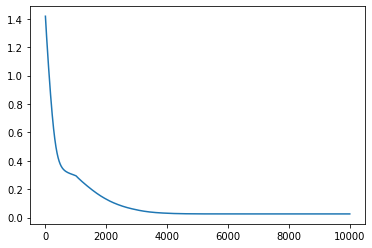

In [31]:
plt.plot(loss_plt)

In [32]:
print(params)

[Parameter containing:
tensor([[-0.1772, -0.2318, -0.0439, -0.2047, -0.0071,  0.3592, -0.3338, -0.2617,
          0.2285,  0.0010, -0.3302, -0.0050,  0.1202, -0.2496, -0.1187,  0.0977,
         -0.2178, -0.4704, -0.1933, -0.0272,  0.1664, -0.0536,  0.0515, -0.1215,
         -0.2529],
        [ 0.2931, -0.2127, -0.2787, -0.2612,  0.0252, -0.1247,  0.0708,  0.0261,
         -0.1987, -0.0253,  0.3851, -0.1950, -0.1634, -0.0660, -0.3524, -0.0368,
         -0.0223, -0.2892,  0.1059, -0.1723,  0.0665,  0.0758, -0.0779,  0.2359,
         -0.2849],
        [-0.1128,  0.1949,  0.0774, -0.2349,  0.1543,  0.2066, -0.0080,  0.2420,
          0.2905, -0.0984,  0.4050,  0.0778,  0.0959, -0.0132, -0.0104, -0.2149,
          0.2174,  0.0151, -0.1286, -0.4644, -0.1725, -0.0551,  0.1271, -0.1466,
          0.1053],
        [-0.1210, -0.3972, -0.1000,  0.0499, -0.1435,  0.2192,  0.2909,  0.0802,
         -0.1055,  0.1596, -0.0150, -0.0842,  0.4077, -0.0714, -0.1258,  0.2326,
          0.2696,  0.1011, -0

In [33]:
W1 = params[0].requires_grad_(False)
W2 = params[1].requires_grad_(False)

In [34]:
W1.size()

torch.Size([20, 25])

In [2]:
# Masked autoencoder (linear)
# Note prob is the un-masked probability
def binary_mat_generator(prob, m, n):
    num1 = int(n*prob) # num1 of entries is 1 in every row
    num0 = n - num1
    vec = np.concatenate([np.zeros(num0), np.ones(num1)])
    mat = np.tile(vec, (m, 1))
    idx = np.random.rand(*mat.shape).argsort(axis=1)
    mat_shuffle = np.take_along_axis(mat, idx, axis=1)
    return torch.tensor(mat_shuffle).float()
    

class M_LAE(nn.Module):
    def __init__(self, prob, m, n):
        super(M_LAE, self).__init__()
        self.mask = binary_mat_generator(prob, m, n)
        w1 = nn.Linear(n, n, bias=False)
        w2 = nn.Linear(n, n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X):
        Y = torch.mul(self.mask, X)
        Y = self.body(Y)
        return Y

In [93]:
prob = 0.4
m = 200
n = 50

inputs = torch.rand(m, n)
targets = inputs

In [116]:
m_net = M_LAE(prob, m, n)

learning_rate = 0.001
epochs = 10000
counter = 1000
criterion = nn.MSELoss()
optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)

In [117]:
"""
# version 1
loss_plt = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = m_net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    loss_plt.append(loss.item())
    if epoch % counter == 0:
        print('epoch: ', epoch, 'loss: ', loss.item())
    if epoch == 6000:
        learning_rate /= 3
        optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)
"""

# version 2
N = 40
loss_plt = []
for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    #N = torch.randint(20, 60, (1,))[0]
    for i in range(N):
        outputs = m_net(inputs)
        loss = criterion(outputs, targets)
        loss_total += loss
    loss_total /= N
    loss_total.backward()
    optimizer.step()
    loss_plt.append(loss_total.item())
    if epoch % counter == 0:
        print('epoch: ', epoch, 'loss: ', loss_total.item())
    if epoch == 6000:
        learning_rate /= 3
        optimizer = optim.Adam(m_net.body.parameters(), lr=learning_rate)

epoch:  0 loss:  0.36113861203193665
epoch:  1000 loss:  0.05491527169942856
epoch:  2000 loss:  0.05458786338567734
epoch:  3000 loss:  0.05457066744565964
epoch:  4000 loss:  0.05456827953457832
epoch:  5000 loss:  0.05456792190670967
epoch:  6000 loss:  0.05456789582967758
epoch:  7000 loss:  0.05456792190670967
epoch:  8000 loss:  0.05456789582967758
epoch:  9000 loss:  0.05456789582967758


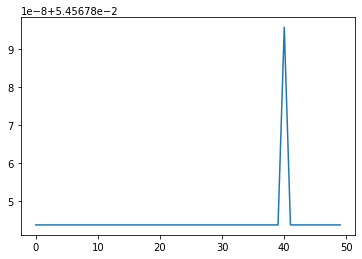

In [118]:
plt.plot(loss_plt[-50:])

In [119]:
params = list(m_net.body.parameters())

In [120]:
W1 = params[0].requires_grad_(False)
W2 = params[1].requires_grad_(False)

In [126]:
N = 100000
gradient1 = 0
for i in range(N):
    X = inputs
    Y = torch.mul(binary_mat_generator(prob, m, n), X)
    gradient1 += mm(transpose(W2, 0, 1), mm(mm(W2, mm(W1, transpose(Y, 0, 1))-transpose(X, 0, 1)), Y))
gradient1 / N

tensor([[ 11.1510,  18.0504,  15.9387,  ...,  15.8014,  19.6703,  18.7646],
        [-39.5821, -40.6497, -35.3739,  ..., -38.0789, -38.7425, -42.2492],
        [ 21.5838,  21.4273,  19.3667,  ...,  21.7175,  22.0442,  23.8687],
        ...,
        [ 11.0461,  13.6170,  12.7003,  ...,   8.3668,  12.6103,  14.0103],
        [-33.9031, -37.3703, -31.4176,  ..., -35.4275, -37.3163, -37.2849],
        [-27.6109, -28.6940, -27.1520,  ..., -27.8542, -26.3111, -37.1343]])

In [121]:
X = inputs
Xt = transpose(X, 0, 1)
mean_m = torch.ones(m, n) * prob
square_m = torch.ones(n, n) * prob**2
square_m.fill_diagonal_(prob)
mm(transpose(W2, 0, 1), mm(W2, mm(W1, torch.mul(square_m, mm(Xt, X))))-mm(Xt, torch.mul(mean_m, X)))

tensor([[ 1.5867,  2.3149,  2.1477,  ...,  0.8232,  2.5456,  0.9676],
        [-3.3828, -1.2988, -1.4688,  ..., -1.4965, -1.1829, -2.2164],
        [ 1.8535,  1.3424,  3.1321,  ...,  1.4368,  1.0818,  2.3889],
        ...,
        [-0.3858,  1.8442,  0.5111,  ...,  0.2836,  0.2827,  0.9305],
        [-1.4747, -3.1841, -0.3495,  ..., -1.3665, -1.1852, -1.7795],
        [-0.9216, -1.7714, -1.6635,  ...,  0.4920,  0.0747, -4.6179]])